1.このSprintについて

Sprintの目的
セグメンテーションの精度を向上させる

どのように学ぶか
Kaggleコンペティションの情報を参考にセグメンテーションの精度を向上させます。



2.セグメンテーションの精度向上

前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行います。


TGS Salt Identification Challenge | Kaggle


3.事前準備
このSprintでは、以下のバージョンを使用します。

TensorFrow: 1.14.0
Keras: 2.3.1

ResNetとVGGの課題用コードにアクセスし、パスワード入力欄に1963を入力します。
アクセス先からMEF_sprint20_03_models_pretrained_and_more.ipynbをダウンロードしてください。
ダウンロードしたファイルをGoogle Colabの「ファイルを開く」からアップロードすることで、ファイルの中身を閲覧できます。

【問題1】コードレビュー
事前準備でダウンロードしたコードは、転移学習を使用してセグメンテーションの精度を改善したコードです。
このコードについて、レビューを行ってください。


《視点例》


前回使用した実装とはどのように違うのか
転移学習をどのように行っているか


In [1]:
#前回使用した実装とはどのように違うのか
# ResNetのスキップコネクションと、U-NetのContracting Pathの発想はほとんど同じで、
# 大きな違いはEncoderとDecoderの間に張るということだけです。
# ResNetはDecoderのないシンプルなCNNですが、レイヤーの間にこのような配線（スキップコネクション）
# を追加することで、勾配消失に強いという特徴があり
# U-Netが一般的なAEと大きく異なる点2は、EncoderとDecoderの間にはしごのように配線があるということです。
# 残差ブロックでは、畳込み層とSkip Connectionの組み合わせになっている。2つの枝から構成されていて、
# それぞれの要素を足し合わせる。残差ブロックの一つはConvolution層の組み合わせで、もう一つはIdentity関数となる。
# こうすれば、仮に追加の層で変換が不要でもweightを0にすれば良い。
# 残差ブロックを導入することで、結果的に層の深度の限界を押し上げることができ、精度向上を果たすことが出来た。

#転移学習をどのように行っているか
# 残差ブロックでは、畳込み層とSkip Connectionの組み合わせになっている。
# 2つの枝から構成されていて、それぞれの要素を足し合わせる。
# 残差ブロックの一つはConvolution層の組み合わせで、もう一つはIdentity関数となる。
# こうすれば、仮に追加の層で変換が不要でもweightを0にすれば良い。
# 残差ブロックを導入することで、結果的に層の深度の限界を押し上げることができ、精度向上を果たすことが出来た。

【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

In [30]:
from keras.applications.vgg19 import VGG19
input_size = (224, 224, 3)
K.clear_session()
VGG_model = VGG19(
        input_shape=input_size, 
        include_top=False,
        weights='imagenet')
VGG_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

In [31]:
from keras.applications.vgg19 import VGG19
def unet_VGG(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):
    
    # Encoder part
    base_model = VGG19(
        input_shape=input_size, 
        include_top=False,
        weights=weights)

    encoder1 = base_model.get_layer('block1_conv2').output # (224,224,64)
    encoder2 = base_model.get_layer('block2_conv2').output # (112,112,228)
    encoder3 = base_model.get_layer('block3_conv4').output # (56,56,256)
    encoder4 = base_model.get_layer('block4_conv4').output # (28,28,512)
    encoder5 = base_model.get_layer('block5_conv4').output # (14,14,512)

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1) # (14,14,1024)

    # Decoder part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256) 
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1) 
    
    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128) 
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1) 

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    #output = UpSampling2D()(concat1)
    #output = Conv2D(2, 32, activation = None, padding = 'same')(concat1)
    output = decoder_block(
        concat1, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [32]:
input_size = (224, 224, 3)

K.clear_session()
model = unet_VGG(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

In [2]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [3]:
!pip install keras==2.2.0
!pip install tensorflow==1.15
!pip install Keras-Applications==1.0.7

     |████████████████████████████████| 300 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.2.0 which is incompatible.
tensorflow 2.6.0 requires keras-preprocessing~=1.1.2, but you have keras-preprocessing 1.0.1 which is incompatible.
     |████████████████████████████████| 412.3 MB 11 kB/s 
     |████████████████████████████████| 3.8 MB 37.8 MB/s 
     |████████████████████████████████| 50

In [4]:
#ResNet

import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [5]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [6]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [7]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

Data loading & depth merge:

データの読み込みと深度のマージ

In [8]:
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/sample_submission.csv')
# depth = pd.read_csv('../input/depths.csv')
# path = '/content/drive/MyDrive/DIC/ResNet_VGG'

train = pd.read_csv('/content/drive/MyDrive/DIC/ResNet_VGG/input/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DIC/ResNet_VGG/input/sample_submission.csv')
depth = pd.read_csv('/content/drive/MyDrive/DIC/ResNet_VGG/input/depths.csv')

#train_src = '../input/train/'
train_src = '/content/drive/MyDrive/DIC/ResNet_VGG/input/train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1  3cb59a4fdc                                             1 5656
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3  c78c89577c                                              101 1
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...

test:
           id rle_mask
0  3e06571ef3      1 1
1  a51b08d882      1 1
2  c32590b06f      1 1
3  15f7a047c7      1 1
4  e8827bc832      1 1

           id                                           rle_mask    z
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...  312
1  3cb59a4fdc                                             1 5656  603
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...  687
3  c78c89577c                                              101 1  236
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...  805


Load images and masks, examine random sample:
画像とマスクをロードし、ランダムなサンプルを調べます。

In [9]:
# X_train = np.asarray(
#     # [cv2.imread('../input/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
#     [cv2.imread('/content/drive/MyDrive/DIC/ResNet_VGG/input/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
#     dtype=np.uint8) / 255.
# y_train = np.asarray(
#     #[cv2.imread('../input/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
#     [cv2.imread('/content/drive/MyDrive/DIC/ResNet_VGG/input/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
#     dtype=np.uint8) / 255.

# print(X_train.shape, y_train.shape)

In [10]:
# # 画像のロードにかなりの時間がかかるので、読込済みのデータを保存しておく。
# import pickle
# with open('/content/drive/My Drive/DIC/ResNet_VGG/X_train.pkl', 'wb') as xtrain:
#     pickle.dump(X_train, xtrain)

# with open('/content/drive/My Drive/DIC/ResNet_VGG/y_train.pkl', 'wb') as ytrain:
#     pickle.dump(y_train, ytrain)

In [12]:
import pickle
# with open('school.binaryfile', 'rb') as web:
#   techacademy = pickle.load(web)
#   print techacademy

with open('/content/drive/My Drive/DIC/ResNet_VGG/X_train.pkl', 'rb') as xtrain:
  X_train= pickle.load(xtrain)
  print("X_train")
  print(X_train)

with open('/content/drive/My Drive/DIC/ResNet_VGG/y_train.pkl', 'rb') as ytrain:
  y_train = pickle.load(ytrain)
  print("y_train")
  print(y_train)

X_train
[[[0.34117647 0.35686275 0.37254902 ... 0.34901961 0.34117647 0.3372549 ]
  [0.34901961 0.37254902 0.39607843 ... 0.34901961 0.34901961 0.34509804]
  [0.37647059 0.39607843 0.41176471 ... 0.34901961 0.35686275 0.34901961]
  ...
  [0.16470588 0.14117647 0.14117647 ... 0.4        0.40784314 0.41176471]
  [0.18823529 0.17254902 0.18431373 ... 0.40392157 0.41176471 0.42352941]
  [0.20392157 0.19607843 0.20392157 ... 0.40784314 0.41176471 0.42745098]]

 [[0.45098039 0.54117647 0.58823529 ... 0.54901961 0.56078431 0.63137255]
  [0.47843137 0.54509804 0.60392157 ... 0.47058824 0.48627451 0.58431373]
  [0.49019608 0.5372549  0.62745098 ... 0.43921569 0.45098039 0.56470588]
  ...
  [0.77647059 0.69803922 0.45098039 ... 0.4745098  0.52156863 0.52156863]
  [0.70196078 0.65490196 0.45882353 ... 0.44313725 0.49019608 0.49411765]
  [0.63137255 0.6        0.4627451  ... 0.42745098 0.4745098  0.48235294]]

 [[0.46666667 0.50588235 0.54117647 ... 0.46666667 0.45882353 0.45490196]
  [0.54901961 

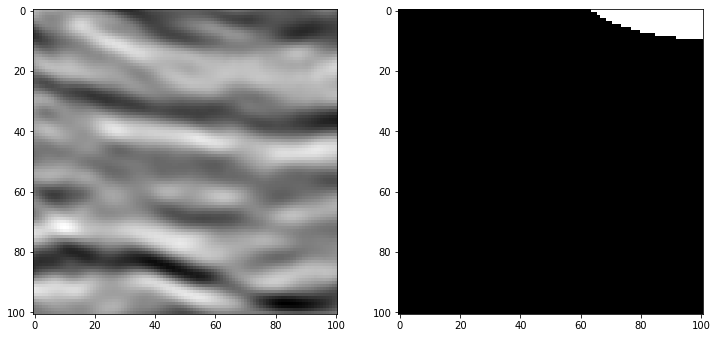

In [13]:
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

Compute salt coverage (this will serve as a basis for stratified split):

ソルトカバレッジを計算します（これは階層化された分割の基礎として機能します）：

In [14]:
#Compute salt coverage (this will serve as a basis for stratified split):
train = compute_coverage(train, y_train)

Prepare data for training:

トレーニング用のデータを準備します。

In [15]:
#Prepare data for training:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


52

Loss functions & metric:

損失関数とメトリック：

In [16]:
#Loss functions & metric:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

Encoder features - ResNet50:
In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers. Default input size will be assumed, which is (224, 224, 3). Layers will be as follows:

'activation_1', shape: (None, 112, 112, 64)
'activation_10', shape: (None, 56, 56, 256)
'activation_22', shape: (None, 28, 28, 512)
'activation_40', shape: (None, 14, 14, 1024)
'activation_49', shape: (None, 7, 7, 2048)
One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call K.clear_session().


エンコーダー機能-ResNet50：ResNet50では、各ブロックがプーリングレイヤーで終了するため、プーリングの直前に中間レイヤーから特徴を抽出できます。 このように、最初のレイヤーが追加のエクストラクターとして追加されると、5つのレイヤーから特徴が抽出されます。 デフォルトの入力サイズ（（224、224、3））が想定されます。 レイヤーは次のようになります。

'activation_1'、shape：（None、112、112、64） 'activation_10'、shape：（None、56、56、256） 'activation_22'、shape：（None、28、28、512） 'activation_40'、shape ：(なし、14、14、1024） 'activation_49'、形状：（なし、7、7、2048）覚えておくべきことの1つは、ノートブックの同じTFセッションでモデルが作成されるたびに、レイヤー 名前が変更されるため、上記のレイヤー名はモデルの最初の作成に対応します。 セッションをリセットするには、K.clear_session（）を呼び出します。

In [17]:
from keras import applications
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________

Decoder blocks:
Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed. For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.

デコーダーブロック：
ResNet50の機能は、セグメンテーションモデルのエンコーダー部分の基礎として機能します。ここで、デコーダー部分が必要になります。 この部分では、独自のブロックを作成する必要があります。 非常に基本的なブロックと2つ目のブロックを作成しましょう。これらの構造は、より複雑な構造になります。

In [18]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

Model definition:
Combine encoder and decoder blocks to create final segmentation model.

モデル定義：
エンコーダーブロックとデコーダーブロックを組み合わせて、最終的なセグメンテーションモデルを作成します。

In [19]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

Inspect created model:

作成されたモデルを検査します。

In [20]:
input_size = (224, 224, 3)


K.clear_session()
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)           

Train model:

In [21]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.
model_depth = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 2  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                 

Validation set prediction and resizing to original size:


検証セットの予測と元のサイズへのサイズ変更： 

In [22]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

Threshold optimization:

しきい値の最適化：

In [23]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [24]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:52<00:00,  1.49s/it]


In [25]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.5913 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.466996
std,0.204939,0.061095
min,0.200000,0.362250
25%,0.370000,0.422563
50%,0.540000,0.461000
75%,0.710000,0.511187
max,0.880000,0.591250


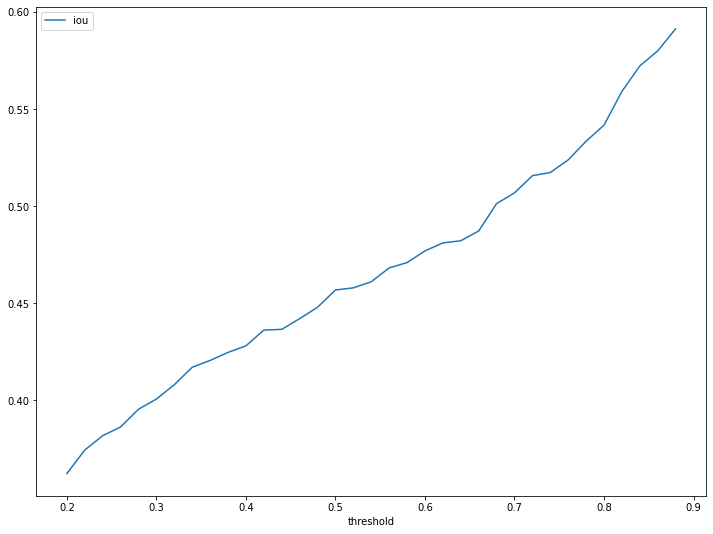

In [26]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

Conclusions:
Pretrained models can be used for segmentation problems:
Some of architectures can be easily adapted to the problem (ie ResNet)
Other architectures may require more experimentation with selection of proper layers for feature extraction and padding (example of using Xception )
You can experiment with selection of layers for feature extraction
For some models, you can also try to experiment with number of encoder/decoder blocks
Threshold optimization is important in problems, where direct metric optimization during training is difficult.
It it possible to use more involved optimization methods (from scipy optimize), although this may not be optimal unless distribution of train and test set are very similar. Overoptimization of threshold or any other parameter on validation set may result in worse test set results.
Experiment with various losses - BCE, Dice, combined BCE with Dice, Lovash loss.
Models trained with various losses may give different results, which may be advantageous when ensembling.
Possible experiments:
Change type of decoder block in created segmentation model
Create your own decoder blocks
Train with other losses
Train longer
Train with BCE/Dice, save the model, then load weights and finetune with Lovash loss
Try different ranges and intervals for threshold optimization


結論：
事前トレーニング済みモデルは、セグメンテーションの問題に使用できます。
一部のアーキテクチャは、問題に簡単に適応できます（つまり、ResNet）。
他のアーキテクチャでは、特徴抽出とパディングに適切なレイヤーを選択して、さらに実験が必要になる場合があります（Xceptionの使用例）
特徴抽出のためのレイヤーの選択を試すことができます
一部のモデルでは、エンコーダー/デコーダーブロックの数を試すこともできます
しきい値の最適化は、トレーニング中の直接的なメトリックの最適化が難しい問題で重要です。
より複雑な最適化手法（scipyoptimizeから）を使用することは可能ですが、トレインとテストセットの分布が非常に類似していない限り、これは最適ではない可能性があります。検証セットのしきい値またはその他のパラメーターを過度に最適化すると、テストセットの結果が悪化する可能性があります。
さまざまな損失を試してください-BCE、ダイス、BCEとダイスの組み合わせ、ロバッシュ損失。
さまざまな損失でトレーニングされたモデルは、異なる結果をもたらす可能性があり、アンサンブルするときに有利になる可能性があります。
可能な実験：
作成したセグメンテーションモデルのデコーダーブロックのタイプを変更します
独自のデコーダーブロックを作成する
他の損失で訓練する
より長く訓練する
BCE / Diceでトレーニングし、モデルを保存してから、ウェイトをロードし、Lovash損失で微調整します
しきい値の最適化のためにさまざまな範囲と間隔を試してください


In [27]:
np.int32(0.7 > 1)

0

In [28]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

VGG19で記載

In [33]:
K.clear_session()

model_depth = unet_VGG(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_VGG.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)

epochs = 2  
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [34]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

In [35]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:54<00:00,  1.54s/it]


In [36]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.3609 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.183136
std,0.204939,0.047584
min,0.200000,0.147375
25%,0.370000,0.152688
50%,0.540000,0.167375
75%,0.710000,0.182375
max,0.880000,0.360875


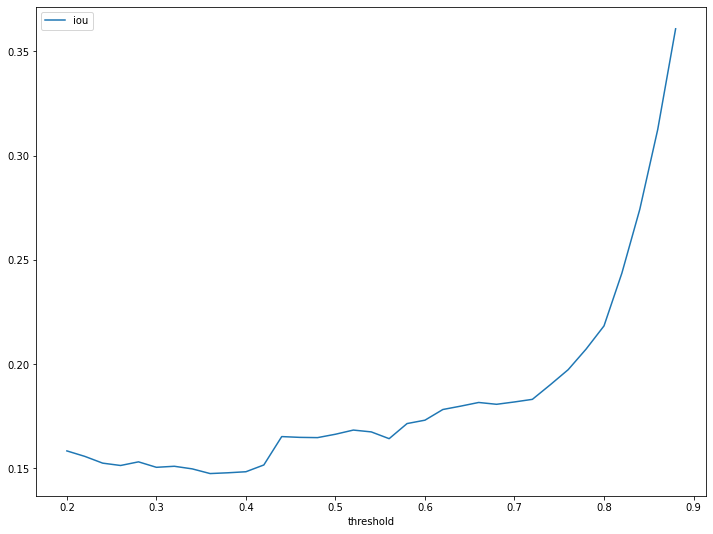

In [37]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

ベストIoUで比較すると、ResNetが0.5913で、VGGが0.3609である。つまり、ResNetの方が精度が高いことが分かった。